In [25]:
# STDP unsupervised SNN learning model
# Pruned
# Digit recognition (MNIST)

import numpy as np 
import struct
import matplotlib.pyplot as plt

from brian2 import *

%matplotlib inline

In [2]:
# read in training data

batch_tot = 6

data_train = []

n_input = 0
n_sample = 0

for batch_index in range(batch_tot):
    with open("./dataset/Fashion MNIST/pst_train_{0}.txt".format(batch_index), "r") as f:
        n_inputNeuron, n_newSample = [int(x) for x in next(f).split()]
        if (batch_index == 0):
            n_input = n_inputNeuron
        n_sample = n_sample + n_newSample
        for line in f:
            data_train.append([float(x) for x in line.split()])


In [3]:
# read in MNIST labels

label_train = []
n_sample = 60000

with open("./dataset/Fashion MNIST/train_label.txt", "r") as f:
    for line in f:
        label_train.append(int(line))

In [4]:
# Set up parameter for modle training
# Network Construction
start_scope()

prefs.codegen.max_cache_dir_size = 0

# Model parameters ===========================================================
# size of first layer
n_input = 784

# synapse weight threshold for pruning
w_th = 0.5

# neuron parameters *******************************************************
# input neuron  -----------------------------------------------------------
# input spike rate multiplier
rate_multiplier = 10*Hz

# excitatory neuron parameters  ---------------------------------------------
# number of excitatory neurons
n_exc = 100

# membrane time constant
tau_exc = 50*ms

# initial threshold
vt_exc_0 = 0.02

# initial rest threshold
vt_exc_rest_0 = 0.02

# threshold increment ratio
vt_exc_inc = 0.05

# max threshold
vt_exc_max = 1

# threshold decrese time constant
# (was 2000*ms)
vt_exc_tau = 1000*ms

# neuron dynamics
eqs_exc = '''
dv/dt = -v/tau_exc : 1
dvt_exc/dt = (vt_exc_rest-vt_exc)/vt_exc_tau : 1
vt_exc_rest : 1
n_fire : 1
'''

# inhibitory neuron parameters ---------------------------------------------
# number of inhibitory neurons
n_inh = 100

# membrane time constant
tau_inh = 50 * ms

# threshold
vt_inh = 0.2

# neuron dynamics
eqs_inh = '''
dv/dt = -v/tau_inh : 1
'''

# synapse parameters  ***********************************************

# input synapses ---------------------------------------------------
# neuron potential scaler
scaler = 0.1 / 2500

# synapse weight learning rate
eta = 0.1

# weight change offset (how much negative weight change to have)
# 0 for NO negative weight change
# 1 for NO positive weight change
offset = 0.5

# max weight
#wmax = clip(500 * eta, 0, 1)
wmax = 1

# min weight
wmin = 0.0

# weight change time constant
tauw = 50 * ms

# activity time constant
taua = 500 * ms

# activity max
amax = 1

# axtivity min
amin = 0

# activity increment
ainc = 0.05

# synapse dynamics
synapse_dynamic = '''
w : 1
new_eta : 1
delta_w : 1
pre_last : second
da/dt = (amin - a)/taua : 1 (event-driven)
'''

synapse_pre_action = '''
a += ainc * (amax - a)
v_post += w * scaler
'''

synapse_post_action = '''
delta_w = eta * (a - offset)
delta_w = delta_w * (wmax - w) * int(delta_w > 0) + delta_w * (w - wmin) * int(delta_w < 0)
w = clip(w + delta_w, 0, 1)
a = 0
'''

# v_post = clip(v_post + w, 0, 1)v_post = clip(v_post + w, 0, 1)

# synapse_post_action = '''
# delta_w = eta * ((exp((pre_last - t) / tauw) - offset))
# delta_w = delta_w * (wmax - w) * int(delta_w > 0) + delta_w * (w - wmin) * int(delta_w < 0)
# w = clip(w + delta_w, 0, 1)
# '''

# synapse_post_action = '''
# new_eta = eta
# delta_w = eta * ((exp((pre_last - t) / tauw) - offset)) * (wmax - w)
# w = clip(w + delta_w, 0, 1)
# '''

# excitatory synapses ----------------------------------------------------
# synapse weight
exc_w_0 = 1

# synapse dynamics
exc_dynamic = '''
exc_w : 1
'''

# synapse on pre action
exc_pre_action = '''
v_post += exc_w
'''

# inhibitory synapses ----------------------------------------------------
# synapse weight
inh_w_0 = 0.1

# synapse dynamics
inh_dynamic = '''
inh_w : 1
'''

# synapse on pre action
inh_pre_action = '''
v_post = v_post * inh_w_0
'''

# Set up neurons ==========================================================
# set up input layer ******************************************************

input_layer = PoissonGroup(n_input, data_train[0]*rate_multiplier)

# set up excitatory layer *************************************************

exc_layer = NeuronGroup(
    n_exc, 
    eqs_exc, 
    threshold="v>vt_exc", 
    refractory="5*ms", 
    reset="v=0", 
    method="exact", 
    events={"homeo" : "v>vt_exc"})

exc_layer.vt_exc = vt_exc_0
exc_layer.vt_exc_rest = vt_exc_rest_0
exc_layer.n_fire = 0

# neuron action on spike firing event
exc_layer.run_on_event("homeo", '''vt_exc = vt_exc + 0.01 * (vt_exc_max - vt_exc)''')
# exc_layer.run_on_event("homeo", "vt_exc = vt_exc + vt_exc_inc * (vt_exc_max - vt_exc)")

# set up inhibitory layer **************************************************

inh_layer = NeuronGroup(
    n_inh,
    eqs_inh,
    threshold = "v>vt_inh",
    refractory = "3*ms",
    reset="v=0",
    method="exact"
)


# Set up synapses =============================================================
# Synapses from input layer to excitatory layer *******************************
input_s = Synapses(
    input_layer, 
    exc_layer, 
    synapse_dynamic,
    method = "exact",
    on_pre = synapse_pre_action,
    on_post = synapse_post_action)

input_s.connect()

# Initialize / Randomize input synapses
# for src_index in range(n_input):
#     for dst_index in range(exc_layer.N):
#         input_s.w[src_index, dst_index] = eta * uniform(0.1, 0.9)
input_s.w = (np.random.rand(int(input_s.N/1))*0.5+0.25)
input_s.pre_last = 0*ms

# Synapses from exc to inh ****************************************************
exc_s = Synapses(
    exc_layer,
    inh_layer,
    exc_dynamic,
    on_pre = exc_pre_action
)

exc_s.connect(condition = "i == j")

# initialize weight
exc_s.exc_w = exc_w_0


# Synapses from inh to exc **************************************************
inh_s = Synapses(
    inh_layer,
    exc_layer,
    inh_dynamic,
    on_pre = inh_pre_action
)

inh_s.connect(condition = "i != j")

# initialize weight
inh_s.inh_w = inh_w_0

# Set up data recording ======================================================

# input_spike = SpikeMonitor(input_layer)
# exc_spike = SpikeMonitor(exc_layer)
# inh_spike = SpikeMonitor(inh_layer)

# pre_update_t = StateMonitor(input_s, "pre_last", record=True)

# input_w = StateMonitor(input_s, "w", record=True)

# delta_w_mo = StateMonitor(input_s, "delta_w", record=True)

# exc_v = StateMonitor(exc_layer, "v", record=True) 

# exc_vt = StateMonitor(exc_layer, "vt_exc", record=True)


#inh_state = StateMonitor(inh_layer, 'v', record = True)

# run(50*ms)

# exc_state = StateMonitor(exc_layer, 'v', record = True)
# neuron_vt_record = SpikeMonitor(exc_layer)

weights_2d_tot = []
updates_2d_tot = []
threshold_2d_tot = []

TypeError: Object of type <class 'brian2.core.clocks.DefaultClockProxy'> does not have dimensions

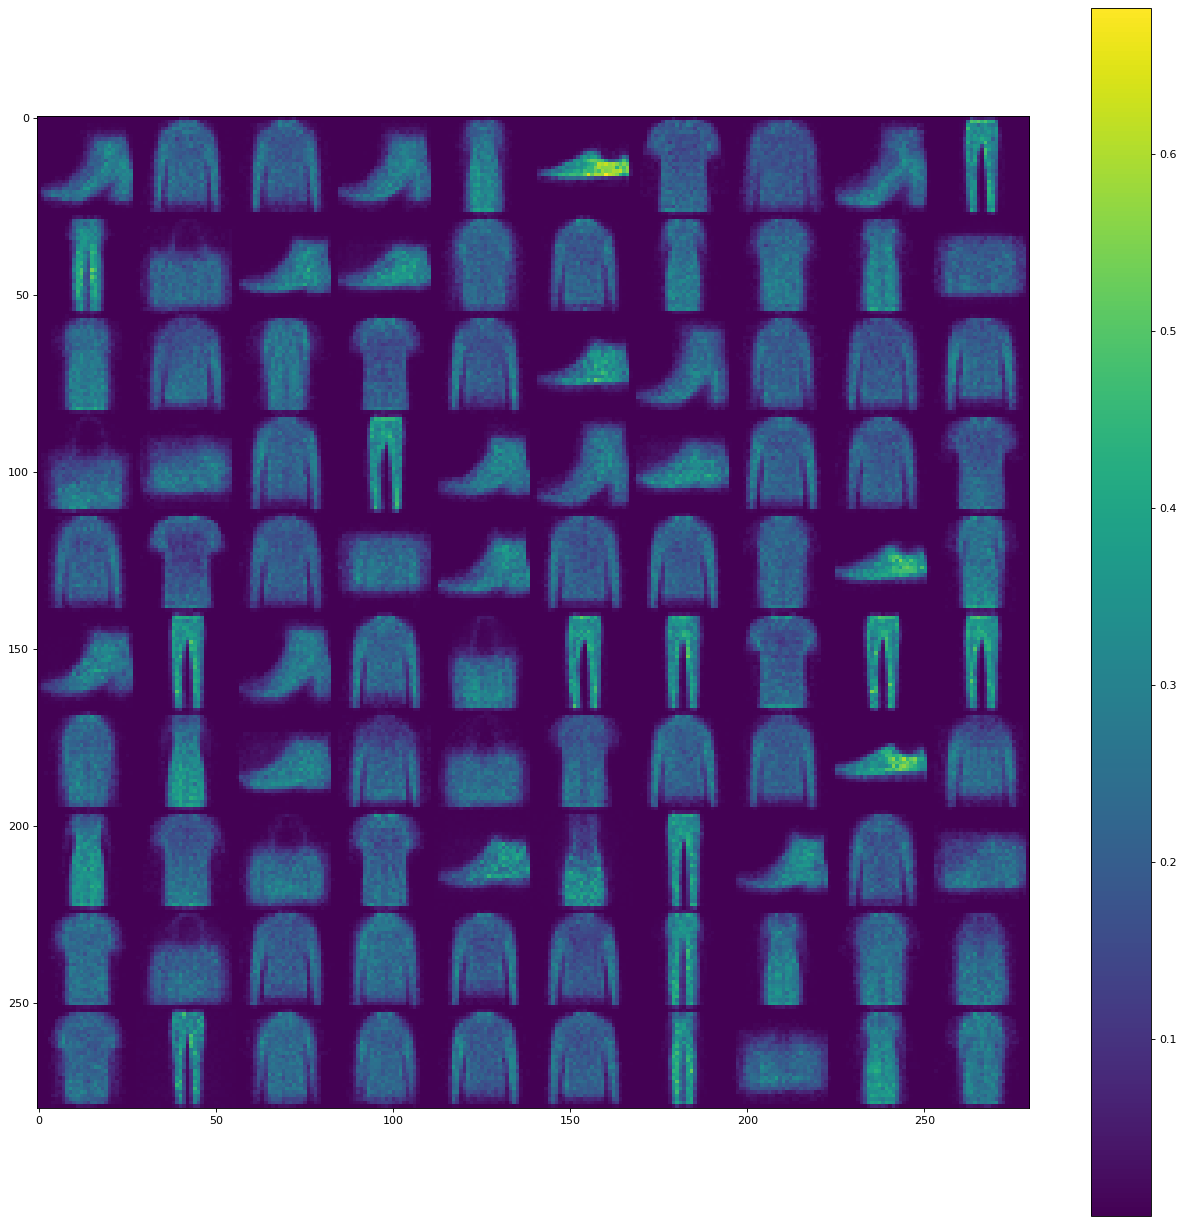

In [5]:
# feature-training model

step_size = 10000

start = 0

stop = start + step_size

for sample in range(start, stop):    

    if label_train[sample] > -1:

        # sequantially lower certain neuron's threshold
        input_s

        # print("{0:.2g}% done...".format(sample / n_tot_sample * 100))

        # set input layer rates
        input_layer.rates = data_train[sample] * rate_multiplier

        # learning rate decay after first 100 samples
        #if sample > 100:
        #    eta = eta / sqrt(sample - 100 )

        # reset last pre-synaptic neuron fire time to 0
        #input_s.pre_last = 0*ms

        # reset voltage to 0
        exc_layer.v = 0

        # reset activity weight
        input_s.a = 0

        # reset delta w
        input_s.delta_w = 0

        # reset total_offset
        #input_s.total_offset = 0
        
        run(50*ms)

        # record weight distribution every 10 runs
    if sample % 1000 == 0:
        weights_2d = np.zeros((10*28, 10*28))
        updates_2d = np.zeros((10*28, 10*28))
        threshold_frame = []
        for neuron_row in  range(10):
            threshold_row = []
            for neuron_col in range(10):
                neuron_index = neuron_row * 10 + neuron_col
                threshold_row.append(exc_layer.vt_exc[neuron_index])
                for input_row in range(28):
                    for input_col in range(28):
                        input_index = input_row * 28 + input_col
                        x = neuron_row * 28 + input_row
                        y = neuron_col * 28 + input_col
                        weights_2d[x][y] = input_s.w[input_index, neuron_index]
                        updates_2d[x][y] = input_s.delta_w[input_index, neuron_index]
            threshold_frame.append(threshold_row)
        threshold_2d_tot.append(threshold_frame)
        weights_2d_tot.append(weights_2d)
        updates_2d_tot.append(updates_2d)


weights_2d = np.zeros((10*28, 10*28))
for neuron_row in  range(10):
    for neuron_col in range(10):
        neuron_index = neuron_row * 10 + neuron_col
        for input_row in range(28):
            for input_col in range(28):
                input_index = input_row * 28 + input_col
                x = neuron_row * 28 + input_row
                y = neuron_col * 28 + input_col
                weights_2d[x][y] = input_s.w[input_index, neuron_index]

plt.figure(figsize = (20, 20), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.imshow(weights_2d)
colorbar()

In [234]:
label_train[10000]

IndexError: list index out of range

In [20]:
len(weights_2d_tot)

0

(0, 20)

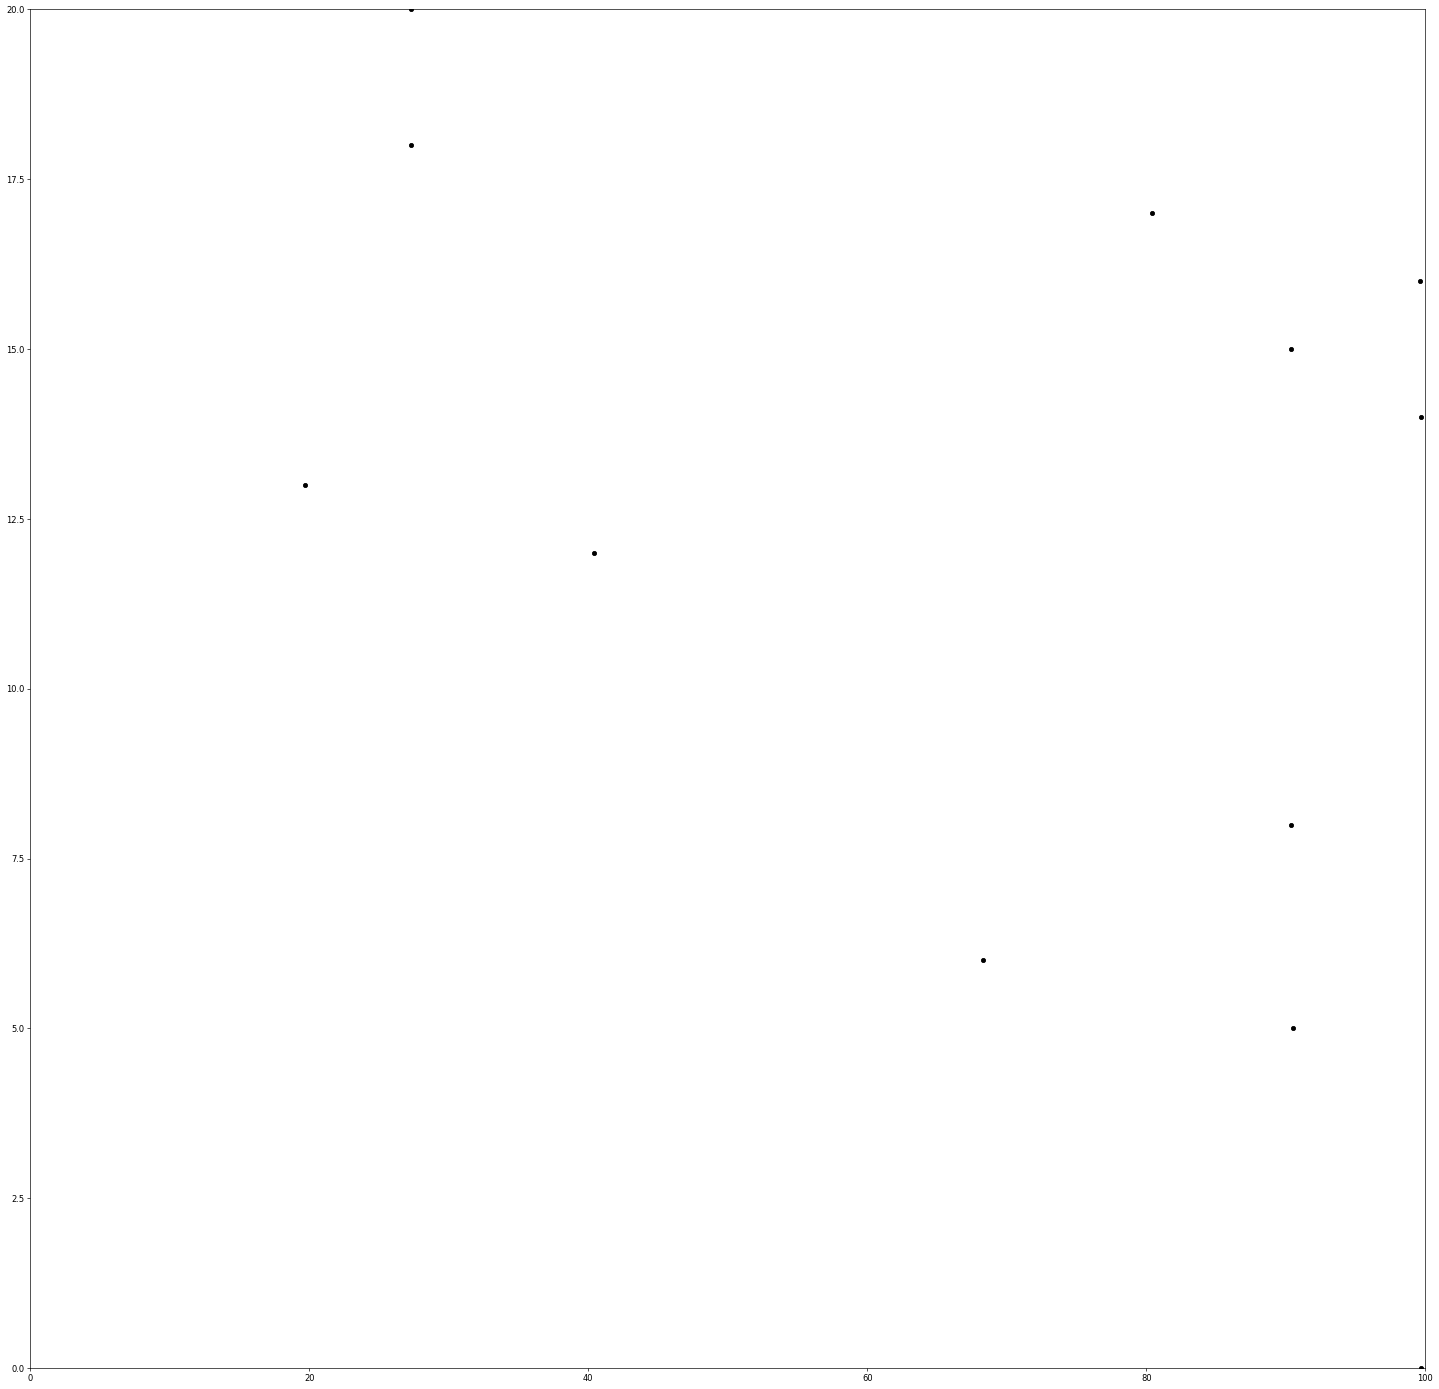

In [44]:
figure(figsize = (30, 30), dpi = 60, facecolor = 'w', edgecolor = 'k')
plot(neuron_vt_record.t/(1*ms), neuron_vt_record.i, '.k', ms=10)
xlim([0, 100])
ylim([0, 20])

(0, 20)

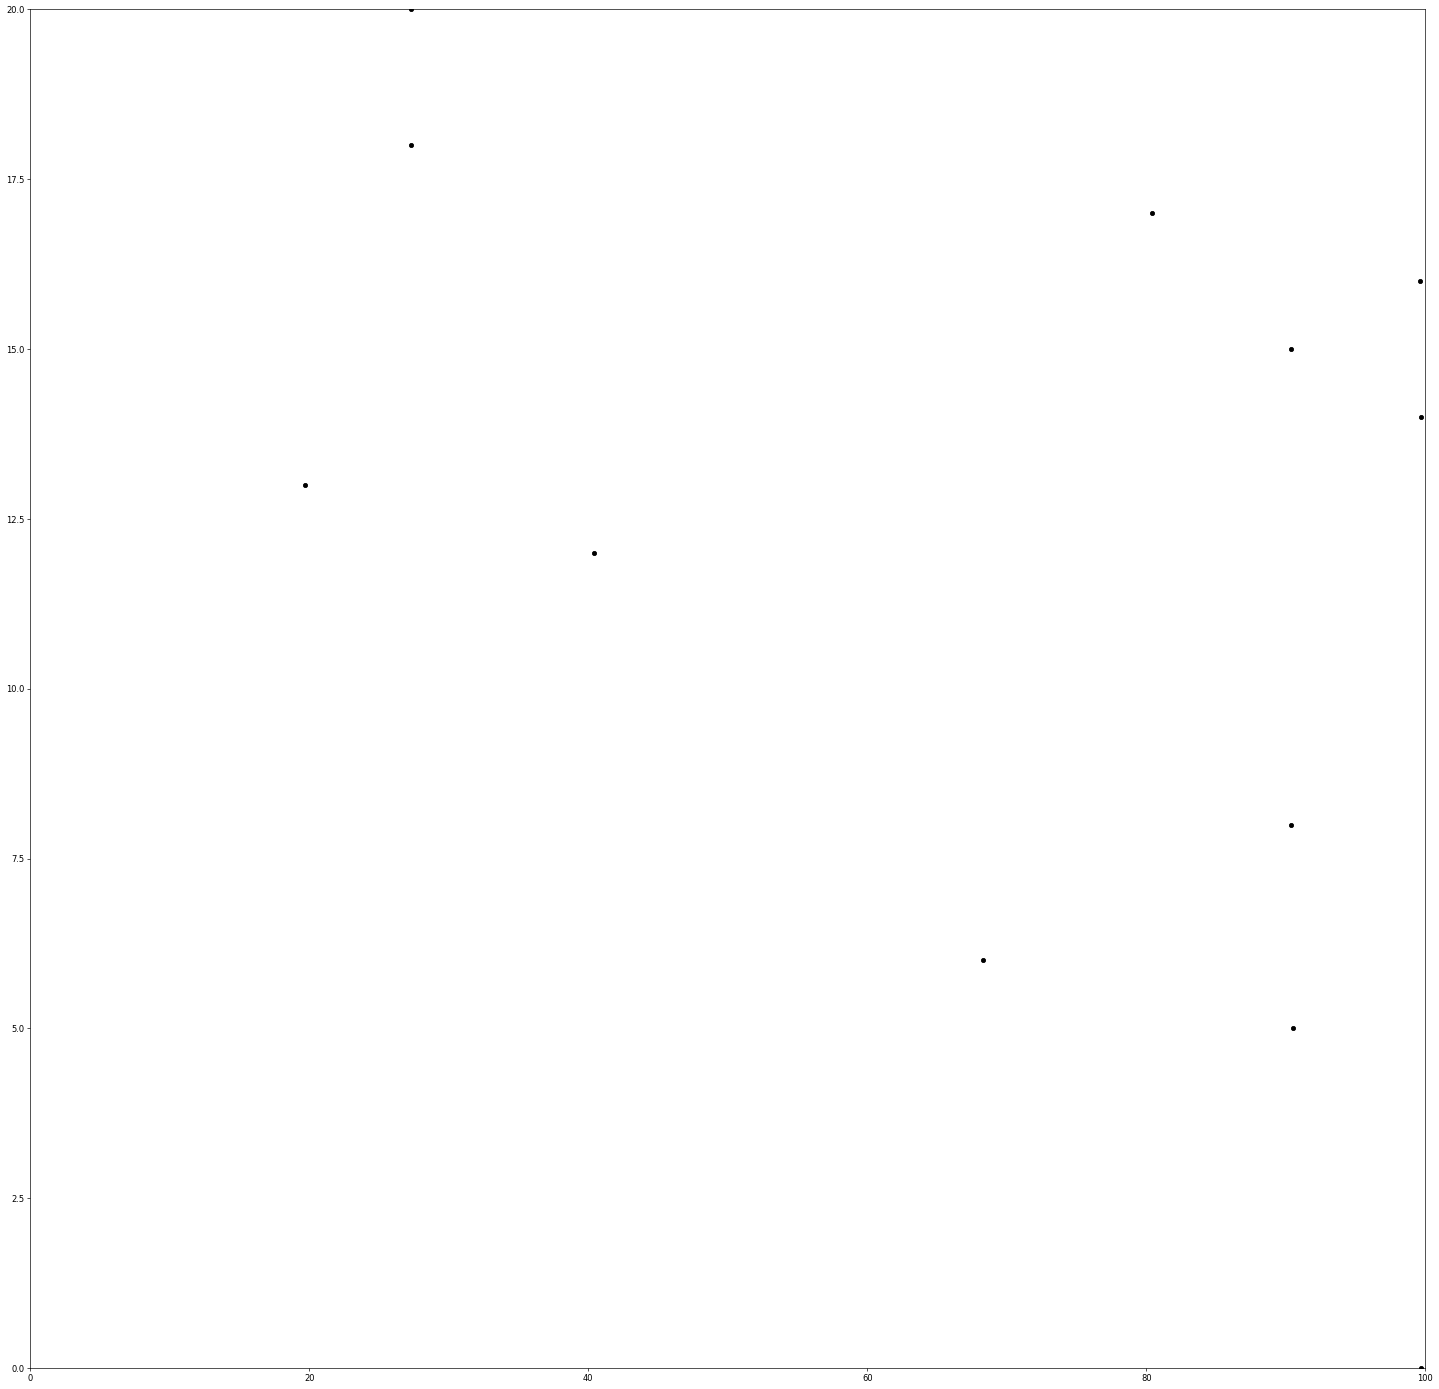

In [43]:
figure(figsize = (30, 30), dpi = 60, facecolor = 'w', edgecolor = 'k')
plot(neuron_vt_record.t/(1*ms), neuron_vt_record.i, '.k', ms=10)
xlim([0, 100])
ylim([0, 20])

In [67]:
np.max(weights_2d)

0.762409772012072

In [43]:
0.776

2

0.02505295722790117

In [19]:
step_index = 0
imshow(threshold_2d_tot[step_index])
colorbar()

plt.figure(figsize = (20, 20), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.imshow(weights_2d_tot[step_index])
colorbar()

plt.figure(figsize = (20, 20), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.imshow(updates_2d_tot[step_index], cmap = "RdBu_r", vmax = max([abs(max(input_s.delta_w)), abs(min(input_s.delta_w))]), vmin = -max([abs(max(input_s.delta_w)), abs(min(input_s.delta_w))]))
colorbar()


data_image = []
data_row = []
for x in range(len(data_train[step_index])):
    data_row.append(data_train[step_index][x])
    if ((x + 1)%28 == 0):
        data_image.append(data_row)
        data_row = []

plt.figure(figsize = (20, 20), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.imshow(data_image, cmap = "gray")
colorbar()

IndexError: list index out of range

In [8]:
# save synapse weight
with open("./input_synapse_weight_0-3-20.txt", "w") as f:
    f.write("{0}\n".format(int(input_s.N/1)))
    for input_index in range(n_input):
        for exc_index in range(n_exc):
            f.write("{0} {1} {2:.10g}\n".format(input_index, exc_index, input_s.w[input_index, exc_index][0]))

In [9]:
# read in synapse weight
synapse_weight = []
with open("./input_synapse_weight_0-3-20.txt", "r") as f:
    n_synapse = [int(x) for x in next(f).split()]
    for line in f:
        newdata = [float(x) for x in line.split()]
        newdata[:2] = [int(x) for x in newdata[:2]]
        synapse_weight.append(newdata)

In [16]:
# read in training data

batch_tot = 1

data_test = []

n_input = 0
n_sample = 0

for batch_index in range(batch_tot):
    with open("./dataset/Fashion MNIST/pst_train_{0}.txt".format(batch_index), "r") as f:
        n_inputNeuron, n_newSample = [int(x) for x in next(f).split()]
        if (batch_index == 0):
            n_input = n_inputNeuron
        n_sample = n_sample + n_newSample
        for line in f:
            data_test.append([float(x) for x in line.split()])


# read in MNIST labels

label_test = []
n_sample = 10000

with open("./dataset/Fashion MNIST/test_label.txt", "r") as f:
    for line in f:
        label_test.append(int(line))

In [10]:
# Set up parameter for modle training
# Network Construction
start_scope()

prefs.codegen.max_cache_dir_size = 0

# Model parameters ===========================================================
# size of first layer
n_input = 784

# synapse weight threshold for pruning
w_th = 0.5

# neuron parameters *******************************************************
# input neuron  -----------------------------------------------------------
# input spike rate multiplier
rate_multiplier = 10*Hz

# excitatory neuron parameters  ---------------------------------------------
# number of excitatory neurons
n_exc = 100

# membrane time constant
tau_exc = 50*ms

# initial threshold
vt_exc_0 = 0.02

# initial rest threshold
vt_exc_rest_0 = 0.02

# threshold increment ratio
vt_exc_inc = 0.05

# max threshold
vt_exc_max = 1

# threshold decrese time constant
# (was 2000*ms)
vt_exc_tau = 1000*ms

# neuron dynamics
eqs_exc = '''
dv/dt = -v/tau_exc : 1
vt_exc : 1
n_fire : 1
'''

# inhibitory neuron parameters ---------------------------------------------
# number of inhibitory neurons
n_inh = 100

# membrane time constant
tau_inh = 50 * ms

# threshold
vt_inh = 0.2

# neuron dynamics
eqs_inh = '''
dv/dt = -v/tau_inh : 1
'''

# synapse parameters  ***********************************************

# input synapses ---------------------------------------------------
# neuron potential scaler
scaler = 0.1 / 2500

# synapse dynamics
synapse_dynamic = '''
w : 1
'''

synapse_pre_action = '''
v_post += w * scaler
'''

# v_post = clip(v_post + w, 0, 1)v_post = clip(v_post + w, 0, 1)

# synapse_post_action = '''
# delta_w = eta * ((exp((pre_last - t) / tauw) - offset))
# delta_w = delta_w * (wmax - w) * int(delta_w > 0) + delta_w * (w - wmin) * int(delta_w < 0)
# w = clip(w + delta_w, 0, 1)
# '''

# synapse_post_action = '''
# new_eta = eta
# delta_w = eta * ((exp((pre_last - t) / tauw) - offset)) * (wmax - w)
# w = clip(w + delta_w, 0, 1)
# '''

# excitatory synapses ----------------------------------------------------
# synapse weight
exc_w_0 = 1

# synapse dynamics
exc_dynamic = '''
exc_w : 1
'''

# synapse on pre action
exc_pre_action = '''
v_post += exc_w
'''

# inhibitory synapses ----------------------------------------------------
# synapse weight
inh_w_0 = 0.1

# synapse dynamics
inh_dynamic = '''
inh_w : 1
'''

# synapse on pre action
inh_pre_action = '''
v_post = v_post * inh_w_0
'''

# Set up neurons ==========================================================
# set up input layer ******************************************************

input_layer = PoissonGroup(n_input, data_train[0]*rate_multiplier)


# set up excitatory layer *************************************************
exc_layer = NeuronGroup(
    n_exc, 
    eqs_exc, 
    threshold="v>vt_exc", 
    refractory="5*ms", 
    reset="v=0", 
    method="exact",
    events={"fire_record" : "v>vt_exc"})

exc_layer.vt_exc = vt_exc_0
exc_layer.n_fire = 0

# neuron action on spike firing event
exc_layer.run_on_event("fire_record", '''n_fire += 1''')

# set up inhibitory layer **************************************************

inh_layer = NeuronGroup(
    n_inh,
    eqs_inh,
    threshold = "v>vt_inh",
    refractory = "3*ms",
    reset="v=0",
    method="exact"
)


# Set up synapses =============================================================
# Synapses from input layer to excitatory layer *******************************
input_s = Synapses(
    input_layer, 
    exc_layer, 
    synapse_dynamic,
    method = "exact",
    on_pre = synapse_pre_action)

input_s.connect()

# Initialize / Randomize input synapses
# for src_index in range(n_input):
#     for dst_index in range(exc_layer.N):
#         input_s.w[src_index, dst_index] = eta * uniform(0.1, 0.9)
for synapse_info in synapse_weight:
    input_s.w[synapse_info[0], synapse_info[1]] = synapse_info[2]

# Synapses from exc to inh ****************************************************
exc_s = Synapses(
    exc_layer,
    inh_layer,
    exc_dynamic,
    on_pre = exc_pre_action
)

exc_s.connect(condition = "i == j")

# initialize weight
exc_s.exc_w = exc_w_0


# Synapses from inh to exc **************************************************
inh_s = Synapses(
    inh_layer,
    exc_layer,
    inh_dynamic,
    on_pre = inh_pre_action
)

inh_s.connect(condition = "i != j")

# initialize weight
inh_s.inh_w = inh_w_0

# Set up data recording ======================================================

# input_spike = SpikeMonitor(input_layer)
# exc_spike = SpikeMonitor(exc_layer)
# inh_spike = SpikeMonitor(inh_layer)

# pre_update_t = StateMonitor(input_s, "pre_last", record=True)

# input_w = StateMonitor(input_s, "w", record=True)

# delta_w_mo = StateMonitor(input_s, "delta_w", record=True)

# exc_v = StateMonitor(exc_layer, "v", record=True) 

# exc_vt = StateMonitor(exc_layer, "vt_exc", record=True)


#inh_state = StateMonitor(inh_layer, 'v', record = True)

# run(50*ms)

# exc_state = StateMonitor(exc_layer, 'v', record = True)
# neuron_vt_record = SpikeMonitor(exc_layer)

weights_2d_tot = []
updates_2d_tot = []
threshold_2d_tot = []

In [11]:
# create label train
neuron_label = np.zeros((100, 10))

In [12]:
# feature-training model

step_size = 10000

start = 0

stop = start + step_size

for sample in range(start, stop):    
    # sequantially lower certain neuron's threshold
    input_s

    # print("{0:.2g}% done...".format(sample / n_tot_sample * 100))

    # set input layer rates
    input_layer.rates = data_train[sample] * rate_multiplier

    # learning rate decay after first 100 samples
    #if sample > 100:
    #    eta = eta / sqrt(sample - 100 )

    # reset last pre-synaptic neuron fire time to 0
    #input_s.pre_last = 0*ms

    # reset voltage to 0
    exc_layer.v = 0

    # reset fire time
    exc_layer.n_fire = 0

    # reset total_offset
    #input_s.total_offset = 0
    
    run(50*ms)

    for exc_index in range(100):
            neuron_label[exc_index, label_train[sample]] = neuron_label[exc_index, label_train[sample]] + exc_layer.n_fire[exc_index]



In [190]:
neuron_label

array([[  0.,   0.,   1.,   0.,   0.,   0.,  82.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   1.,   0.,  19.,   0.,   0.,  15.,   0.],
       [  0.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,  58.,   0.],
       [ 17.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,  10.,   4.],
       [  0.,   1.,   1.,   2.,  43.,   1.,   0.,  15.,   3., 142.],
       [  0.,   0.,   4.,   1.,   0.,   0.,   0.,   0.,  18.,   0.],
       [  0.,   0.,   0.,  20.,   0.,   1.,   0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   1.,   0.,  90.,   0.,   0.,   0.],
       [102.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   1.,   1.],
       [  0.,   0.,  34.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   5.,   0.,   2.,   0.,   1.,   0.,   0.,   0.],
       [  0., 167.,  18.,   1.,   2.,   0.,   1.,   7.,   7.,   1.],
       [ 22.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  45.,   

In [13]:
neuron_class = []

for neuron_index in range(100):
    neuron_class.append(np.argmax(neuron_label[neuron_index]))
    

In [21]:
len(neuron_class)

100

In [14]:
# save neuron_class
with open("./neuron_class.txt", "w") as f:
    f.write("{0}\n".format(len(neuron_class)))
    for class_label in neuron_class:
        f.write("{0}\n".format(class_label))

In [17]:
for class_label in neuron_class:
    print(class_label)

9
0
0
9
0
7
0
0
9
0
1
8
0
0
0
0
0
0
0
8
0
8
1
0
0
7
0
0
0
2
5
0
0
1
0
9
7
2
0
0
0
0
0
8
9
2
0
0
7
0
9
1
9
2
8
1
1
0
1
1
4
3
9
0
8
0
4
0
7
8
3
0
8
0
9
0
0
0
0
8
0
0
0
4
0
0
1
0
0
0
0
0
4
0
0
0
1
8
3
0


In [24]:
range(int(len(neuron_class)))

range(0, 100)

In [15]:
class_activity = []
for n in range(10):
    print("{0} : {1}".format(n, np.max(neuron_label[:, n])))
    class_activity.append(np.max(neuron_label[:, n]))

0 : 778.0
1 : 726.0
2 : 1212.0
3 : 688.0
4 : 1283.0
5 : 40.0
6 : 840.0
7 : 442.0
8 : 356.0
9 : 364.0


In [16]:
np.std(class_activity)

368.0474018384045